In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
import numpy as np
import os

def load_idx_images(path):
    """
    读取 idx3-ubyte 原始图像文件（不压缩）
    返回 shape = (num_images, rows*cols)，并归一化到 [0,1]
    """
    with open(path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')     
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        # 一次性读入所有像素
        buffer = f.read(num_images * rows * cols)
    data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, rows * cols) / 255.0
    return data

def load_idx_labels(path):
    """
    读取 idx1-ubyte 原始标签文件（不压缩）
    返回 shape = (num_labels,)
    """
    with open(path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')     
        num_labels = int.from_bytes(f.read(4), 'big')
        buffer = f.read(num_labels)
    labels = np.frombuffer(buffer, dtype=np.uint8)
    return labels

def load_data(base_path='.'):
    # 构造各文件完整路径
    train_images = os.path.join(base_path, 'train-images-idx3-ubyte')
    train_labels = os.path.join(base_path, 'train-labels-idx1-ubyte')
    test_images  = os.path.join(base_path, 't10k-images-idx3-ubyte')
    test_labels  = os.path.join(base_path, 't10k-labels-idx1-ubyte')

    # 读取
    x_train = load_idx_images(train_images)
    y_train = load_idx_labels(train_labels)
    x_test  = load_idx_images(test_images)
    y_test  = load_idx_labels(test_labels)

    # 划分验证集：取训练集最后 5000 条
    x_val, y_val = x_train[-5000:], y_train[-5000:]
    x_train, y_train = x_train[:-5000], y_train[:-5000]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)


In [3]:
# Fashion-MNIST 类别名称
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def visualize_data_samples(x_data, y_data, num_samples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_data[i].reshape(28, 28), cmap='gray')
        plt.title(f"{class_names[y_data[i]]} 佘祎凡")
        plt.axis('off')
    plt.suptitle(f"数据集样本 佘祎凡")
    plt.tight_layout()
    plt.show()

def visualize_class_distribution(y_data):
    plt.figure(figsize=(10, 6))
    plt.hist(y_data, bins=range(11), align='left', rwidth=0.8, color='skyblue')
    plt.xticks(range(10), class_names, rotation=45)
    plt.title(f"类别 佘祎凡")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.6)
    plt.tight_layout()
    plt.show()

def visualize_pixel_distribution(x_data):
    pixels = x_data.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(pixels, bins=50, color='green', alpha=0.7)
    plt.title(f"像素值分布 佘祎凡")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve



手动实现权重初始化，这里使用标准差的形式对初始权重进行设置，此为手动设置的常见方法
手动实现softmax分类函数 交叉熵损失函数以及L2正则化

In [4]:
def weight_variable(shape):
    initial = tf.random.normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def softmax(x):
    exp_x = tf.exp(x - tf.reduce_max(x, axis=1, keepdims=True))
    return exp_x / tf.reduce_sum(exp_x, axis=1, keepdims=True)
def get_batches(X, y, batch_size):
    n = X.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        yield X[start:end], y[start:end]
# 6. 手动实现损失函数（交叉熵 + L2 正则）
def compute_loss(y_pred, labels, variables, l2_lambda):
    y_onehot = tf.one_hot(labels, depth=10)
    # 交叉熵
    ce = tf.reduce_mean(-tf.reduce_sum(y_onehot * tf.math.log(y_pred + 1e-8), axis=1))
    # L2 正则
    l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in variables])
    return ce + l2_lambda * l2_loss

In [5]:
def fcnn(image_batch):
    hidden_1 = tf.nn.relu(tf.matmul(image_batch, W_fc1) + b_fc1)
    hidden_2 = tf.nn.relu(tf.matmul(hidden_1, W_fc2) + b_fc2)
    _y = softmax(tf.matmul(hidden_2, W_out) + b_out)
    return _y
#tf.nn.relu 激活函数使用relu
#网络进行矩阵乘法  W dot x+b 

In [6]:
#  设置变量维度 784->200->200->10  (10为最后输出类别个数）
W_fc1 = weight_variable([784, 200])
b_fc1 = bias_variable([200])
W_fc2 = weight_variable([200, 200])
b_fc2 = bias_variable([200])
W_out = weight_variable([200, 10])
b_out = bias_variable([10])

手动实现训练代码并设置epoch，batch_size ,learning_rate,l2_lambda  等可变超参数，对训练过程进行指示
手动实现小批量梯度下降，在shffule的基础上，使用小批量梯度下降可以提高模型的运行效率以及准确性
在每个epoch训练完毕后检验训练效果

In [7]:
def train(train_data, val_data, epochs, batch_size, lr, l2_lambda):
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    variables = [W_fc1, b_fc1, W_fc2, b_fc2, W_out, b_out]
    x_train, y_train = train_data
    x_val, y_val = val_data

    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(1, epochs + 1):
        # 随机打乱
        perm = np.random.permutation(len(x_train))
        x_train_shuf, y_train_shuf = x_train[perm], y_train[perm]

        # 手动小批量梯度下降：for batch in get_batches()
        for xb, yb in get_batches(x_train_shuf, y_train_shuf, batch_size):
            with tf.GradientTape() as tape:
                y_pred = fcnn(xb)
                loss = compute_loss(y_pred, yb, variables, l2_lambda)
            grads = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(grads, variables))

        # 每个 epoch 结束后评估训练及验证集
        y_train_pred = fcnn(x_train)
        y_val_pred = fcnn(x_val)
        train_loss = compute_loss(y_train_pred, y_train, variables, l2_lambda)
        val_loss = compute_loss(y_val_pred, y_val, variables, l2_lambda)
        train_acc = np.mean(tf.argmax(y_train_pred, axis=1).numpy() == y_train)
        val_acc = np.mean(tf.argmax(y_val_pred, axis=1).numpy() == y_val)

        train_loss_hist.append(train_loss.numpy())
        val_loss_hist.append(val_loss.numpy())
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

In [8]:

def plot_curves(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss 曲线 佘祎凡')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy 曲线 佘祎凡')
    plt.legend()
    plt.show()
#绘制曲线
def show_misclassified_samples(x_data, y_true, num_show=10):
    y_pred = fcnn(x_data)  
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
    y_true = y_true  # 真实标签

    misclassified_indices = np.where(y_pred_classes != y_true)[0]

    print(f"总共有 {len(misclassified_indices)} 张图片分类错误。")
    
    # 随机挑选几张展示
    if len(misclassified_indices) < num_show:
        num_show = len(misclassified_indices)
    selected_indices = np.random.choice(misclassified_indices, num_show, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, num_show, i+1)
        plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {y_pred_classes[idx]}, True: {y_true[idx]}")
        plt.axis('off')
    plt.show()

    return misclassified_indices


In [9]:
def evaluate(test_data):
    x_test, y_test = test_data
    y_test_pred = fcnn(x_test)
    preds = tf.argmax(y_test_pred, axis=1).numpy()
    print("\nClassification Report:\n", classification_report(y_test, preds))
    try:
        auc = roc_auc_score(tf.keras.utils.to_categorical(y_test, 10), y_test_pred.numpy(), multi_class='ovo')
        print(f"AUC: {auc:.4f}")
    except:
        print("AUC 计算失败，请检查标签是否完整。")

=== 数据样本可视化 ===


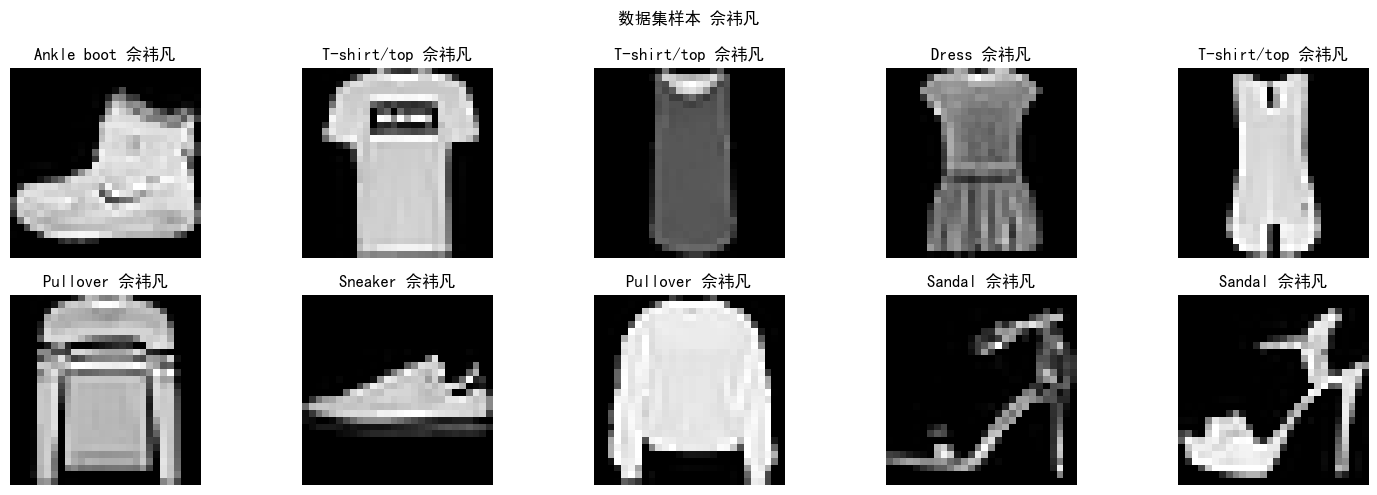

=== 类别分布可视化 ===


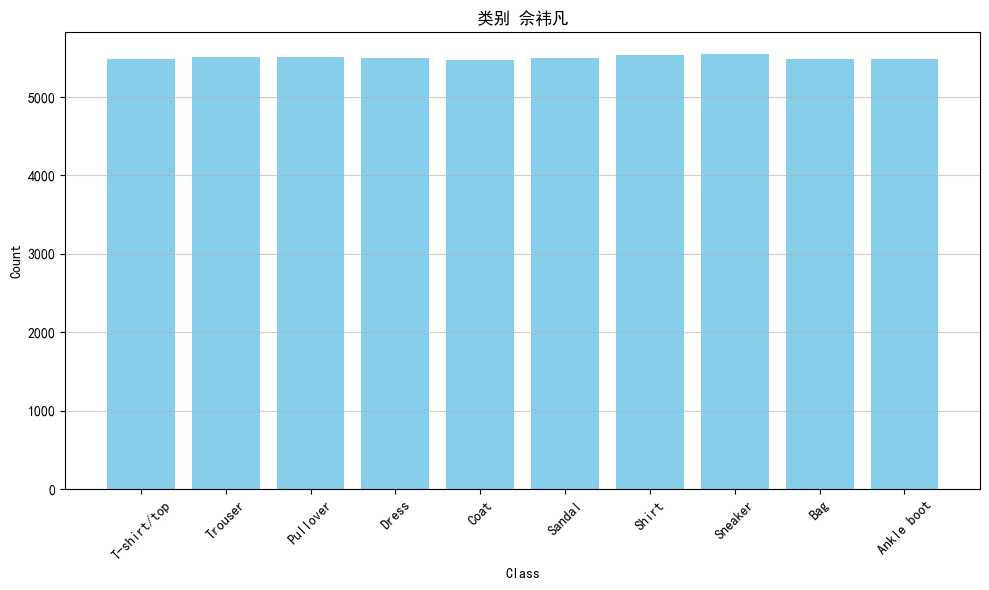

=== 像素值分布可视化 ===


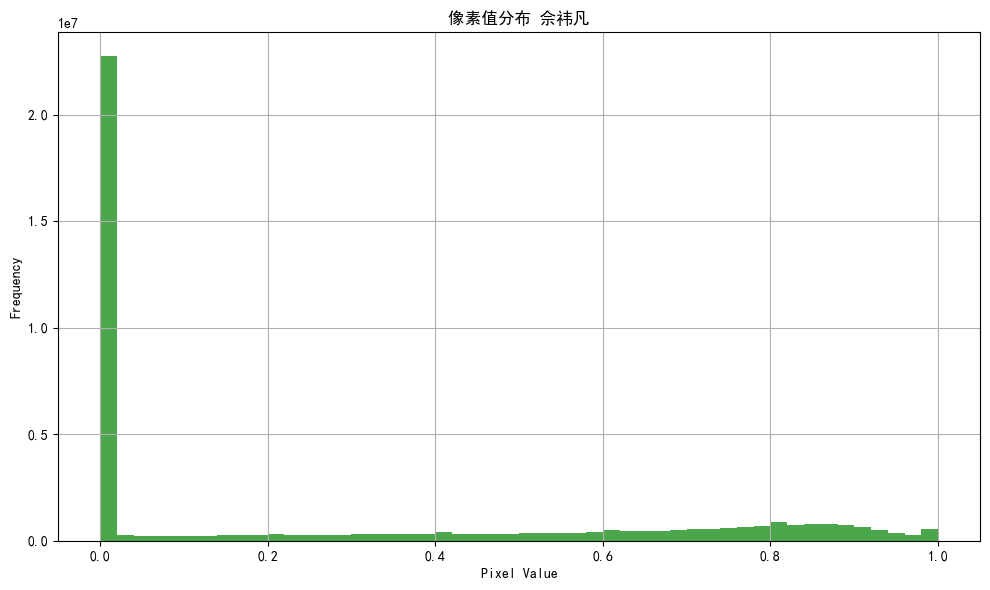

Epoch 1: Train Acc=0.8259, Val Acc=0.8234
Epoch 2: Train Acc=0.8673, Val Acc=0.8586
Epoch 3: Train Acc=0.8121, Val Acc=0.8066
Epoch 4: Train Acc=0.8657, Val Acc=0.8556
Epoch 5: Train Acc=0.8928, Val Acc=0.8774
Epoch 6: Train Acc=0.8926, Val Acc=0.8742
Epoch 7: Train Acc=0.8925, Val Acc=0.8718
Epoch 8: Train Acc=0.8850, Val Acc=0.8624
Epoch 9: Train Acc=0.8785, Val Acc=0.8524
Epoch 10: Train Acc=0.8992, Val Acc=0.8666
Epoch 11: Train Acc=0.9072, Val Acc=0.8818
Epoch 12: Train Acc=0.9124, Val Acc=0.8794
Epoch 13: Train Acc=0.9215, Val Acc=0.8884
Epoch 14: Train Acc=0.9146, Val Acc=0.8828
Epoch 15: Train Acc=0.9096, Val Acc=0.8696
Epoch 16: Train Acc=0.9284, Val Acc=0.8884
Epoch 17: Train Acc=0.9209, Val Acc=0.8872
Epoch 18: Train Acc=0.9282, Val Acc=0.8854
Epoch 19: Train Acc=0.9229, Val Acc=0.8824
Epoch 20: Train Acc=0.9380, Val Acc=0.8896
Epoch 21: Train Acc=0.9369, Val Acc=0.8954
Epoch 22: Train Acc=0.9340, Val Acc=0.8878
Epoch 23: Train Acc=0.9282, Val Acc=0.8790
Epoch 24: Train Acc=

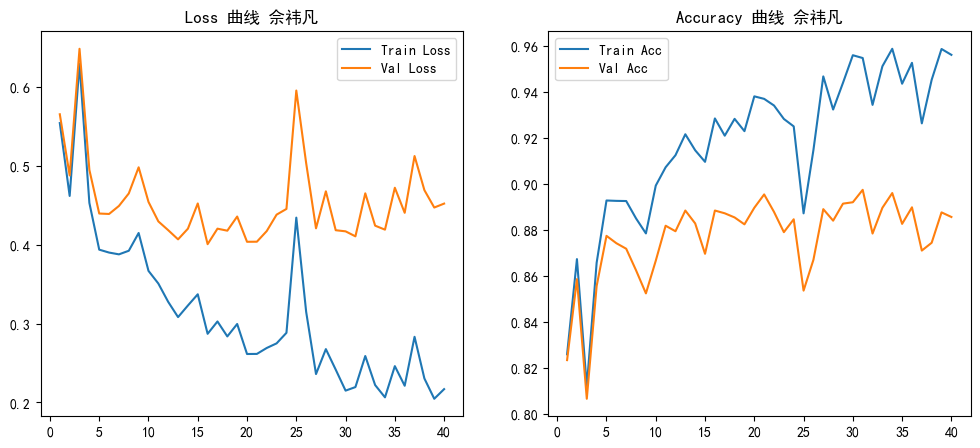


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.98      0.97      0.98      1000
           2       0.75      0.83      0.79      1000
           3       0.95      0.79      0.86      1000
           4       0.75      0.86      0.80      1000
           5       0.98      0.96      0.97      1000
           6       0.75      0.68      0.71      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

AUC: 0.9906


In [10]:
if __name__ == '__main__':
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data(base_path=r"C:\Users\LY\Desktop\ml2\archive")
    # 超参数设置
    epochs = 40         # 训练轮数
    batch_size = 64     # 批量大小
    lr = 0.1            # 学习率
    l2_lambda = 1e-4    # L2 正则系数 λ
    # 数据可视化
    print("=== 数据样本可视化 ===")
    visualize_data_samples(x_train, y_train)
    print("=== 类别分布可视化 ===")
    visualize_class_distribution(y_train)
    print("=== 像素值分布可视化 ===")
    visualize_pixel_distribution(x_train)
    train_loss, val_loss, train_acc, val_acc = train(
        (x_train, y_train), (x_val, y_val), epochs, batch_size, lr, l2_lambda)
    
    plot_curves(train_loss, val_loss, train_acc, val_acc)
    evaluate((x_test, y_test))


#### 从各个计算的指数来看，模型性能表现总体较好。
- 精确率来看，所有类别的精确率均在0.75以上，类别1、3、5、8、9，精确率都超过了0.95，说明模型在预测这些类别时，说明模型学习效果较好。
- 召回率方面，类别1、7、8达到了0.97，表明模型几乎能够识别出所有的真实正样本；但类别3、6召回率偏低，仅为0.79、0.68，说明该类别没有学习到位，也说明类别3、6可能难学。
- F1分数综合了精确率与召回率的表现，所有都维持在0.7以上，大部分类别都达到了0.8以上，其中类别1、5、7、8、9的F1分数都达到了0.95及以上，模型在这些类别上兼顾了高准确率和高召回率，其中1、5、8F1分数更为出众。
- 总体准确率为88%，说明在全部10000个测试样本中，有约8700个样本被正确分类。
- 最后宏平均和加权平均的精确率、召回率和F1分数均约为0.88~0.89，进一步表明模型在各类别上表现比较均衡，没有出现严重偏向个别类别的情况。
从整体评估指标AUC来看，本模型的AUC达到了0.9906，接近于1，表明模型在区分不同类别时具有极高的判别能力，分类器的整体性能非常优秀。

#### 但是通过分析图像可知:
- 随着epoch的增加，Train_acc幅度波动较大，到达0.95而验证集却没有显著提升，趋于稳定，说明模型可能是过拟合了，也有可能是模型本身的架构没办法突破当前的限制。
- 由于设备局限，无法跑更多的epoch,可进一步加大epoch数量，应该准确率会有一定的提升。不过模型本身的架构也差不多是这个水平，难以有突破性的进展。

In [3]:
import csv
import pandas as pd

# 消融实验
下面考虑进行消融实验，为了方便训练，将模型封装成类（MyMLP），便于修改。为了绘图的方便以及节省训练时间，直接将训练结果写入csv文件，直接读取并绘图即可。由于性能有限以及时间限制，消融实验的对比量以及训练量都不是非常充分，但同样可以反应情况，变量一致。


In [4]:

class MyMLP:
    def __init__(self, hidden_units, activation_fn=tf.nn.relu, dropout_rate=0.0, l2_lambda=1e-4):
        self.activation = activation_fn
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.vars = []
        prev = 784#784维度
        for i, units in enumerate(hidden_units):
            W = tf.Variable(tf.random.normal([prev, units], stddev=0.1), name=f'W{i}')
            b = tf.Variable(tf.constant(0.1, shape=[units]), name=f'b{i}')
            self.vars += [W, b]
            prev = units
        W_out = tf.Variable(tf.random.normal([prev, 10], stddev=0.1), name='W_out')
        b_out = tf.Variable(tf.constant(0.1, shape=[10]), name='b_out')
        self.vars += [W_out, b_out]

    def forward(self, x, training=False):
        h = x
        for i in range(0, len(self.vars) - 2, 2):
            W, b = self.vars[i], self.vars[i + 1]
            h = self.activation(tf.matmul(h, W) + b)
            if training and self.dropout_rate > 0:
                h = tf.nn.dropout(h, rate=self.dropout_rate)
        W_out, b_out = self.vars[-2], self.vars[-1]
        logits = tf.matmul(h, W_out) + b_out
        exp_x = tf.exp(logits - tf.reduce_max(logits, axis=1, keepdims=True))
        return exp_x / tf.reduce_sum(exp_x, axis=1, keepdims=True)

    def loss(self, y_pred, y_true):
        y_onehot = tf.one_hot(y_true, depth=10)
        ce = tf.reduce_mean(-tf.reduce_sum(y_onehot * tf.math.log(y_pred + 1e-8), axis=1))
        l2 = tf.add_n([tf.nn.l2_loss(v) for v in self.vars])
        return ce + self.l2_lambda * l2

#  手动小批量训练函数 
def train_model(hidden_units, activation, dropout, l2_lambda,
                lr, batch_size, epochs=10, return_history=False):
    (x_train, y_train), (x_val, y_val), _ = load_data(base_path=r"C:\Users\LY\Desktop\ml2\archive")
    model = MyMLP(hidden_units, activation, dropout, l2_lambda)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)#调用keras 优化器中的SGD设置optimizer
    for epoch in range(epochs):
        idx = np.random.permutation(len(x_train))
        x_shuf, y_shuf = x_train[idx], y_train[idx]
        for i in range(0, len(x_shuf), batch_size):
            xb = x_shuf[i:i + batch_size]
            yb = y_shuf[i:i + batch_size]
            with tf.GradientTape() as tape:
                pred = model.forward(xb, training=True)
                loss = model.loss(pred, yb)
            grads = tape.gradient(loss, model.vars)
            optimizer.apply_gradients(zip(grads, model.vars))
    y_val_pred = model.forward(x_val)
    val_acc = np.mean(tf.argmax(y_val_pred, axis=1).numpy() == y_val)
    return (val_acc, model) if return_history else val_acc

# 保存结果至 CSV 
def save_results_to_csv(results, filename='ablation_results.csv'):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['experiment', 'setting', 'val_accuracy'])
        for exp_name, setting_dict in results.items():
            for setting, acc in setting_dict.items():
                writer.writerow([exp_name, setting, acc])

#将训练数据保存至csv文件后，读取绘图
def plot_results_from_csv(filename='ablation_results.csv'):
    df = pd.read_csv(filename, encoding='utf-8', encoding_errors='ignore')
    groups = df.groupby('experiment')
    for name, group in groups:
        group_sorted = group.sort_values(by='val_accuracy', ascending=False)
        plt.figure(figsize=(8, 5))
        bars = plt.barh(group_sorted['setting'], group_sorted['val_accuracy'],
                        color=plt.cm.plasma(np.linspace(0.2, 0.8, len(group_sorted))))
        plt.title(f'ablation_experiments - {name}', fontsize=14)
        plt.xlabel('v_acc', fontsize=12)
        plt.xlim(0.7, 1.0)
        for bar, acc in zip(bars, group_sorted['val_accuracy']):
            plt.text(acc + 0.002, bar.get_y() + bar.get_height()/2, f'{acc:.3f}', va='center')
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

#  消融实验主函数 
def ablation_experiments():
    results = {}
    archs = {'1layer': [200], '2layer': [200, 200], '3layer': [200, 200, 200]}
    results['arch'] = {name: train_model(hu, tf.nn.relu, 0.0, 1e-4, 0.1, 64, 5) for name, hu in archs.items()}
    l2_list = [0.0, 1e-4, 1e-3]
    results['l2'] = {f"λ={l}": train_model([200, 200], tf.nn.relu, 0.0, l, 0.1, 64, 5) for l in l2_list}
    lr_list = [0.01, 0.1, 0.2]
    results['lr'] = {f"η={lr}": train_model([200, 200], tf.nn.relu, 0.0, 1e-4, lr, 64, 5) for lr in lr_list}
    bs_list = [32, 64, 128]
    results['bs'] = {f"bs={bs}": train_model([200, 200], tf.nn.relu, 0.0, 1e-4, 0.1, bs, 5) for bs in bs_list}
    acts = {'ReLU': tf.nn.relu, 'Sigmoid': tf.nn.sigmoid, 'Tanh': tf.nn.tanh}
    results['act'] = {name: train_model([200, 200], act, 0.0, 1e-4, 0.1, 64, 5) for name, act in acts.items()}
    drops = [0.0, 0.2, 0.5]
    results['drop'] = {f"drop={d}": train_model([200, 200], tf.nn.relu, d, 1e-4, 0.1, 64, 5) for d in drops}
    save_results_to_csv(results)
    plot_results_from_csv()
    return results




In [7]:
def plot_results_from_csv(filename='ablation_results.csv'):
    df = pd.read_csv(filename, encoding='utf-8', encoding_errors='ignore')
    groups = df.groupby('experiment')
    for name, group in groups:
        group_sorted = group.sort_values(by='val_accuracy', ascending=False)
        plt.figure(figsize=(8, 5))
        bars = plt.barh(group_sorted['setting'], group_sorted['val_accuracy'],
                        color=plt.cm.plasma(np.linspace(0.2, 0.8, len(group_sorted))))
        plt.title(f'消融实验 - {name}-佘祎凡', fontsize=14)
        plt.xlabel('v_acc', fontsize=12)
        plt.xlim(0.7, 1.0)
        for bar, acc in zip(bars, group_sorted['val_accuracy']):
            plt.text(acc + 0.002, bar.get_y() + bar.get_height()/2, f'{acc:.3f}', va='center')
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()


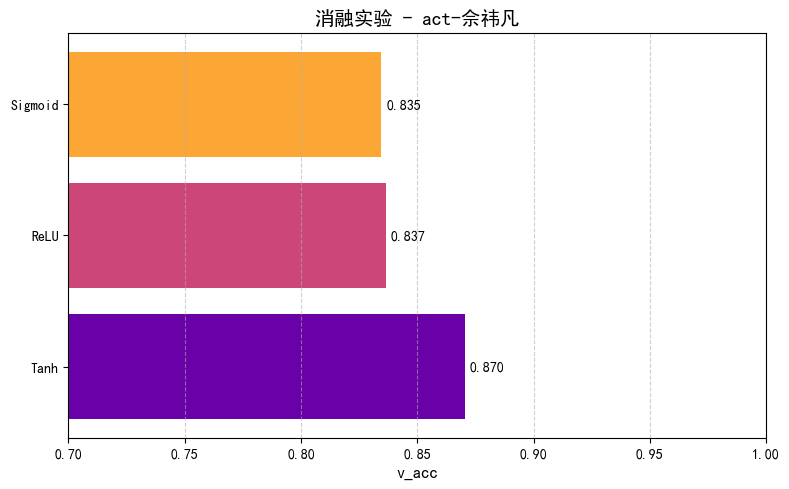

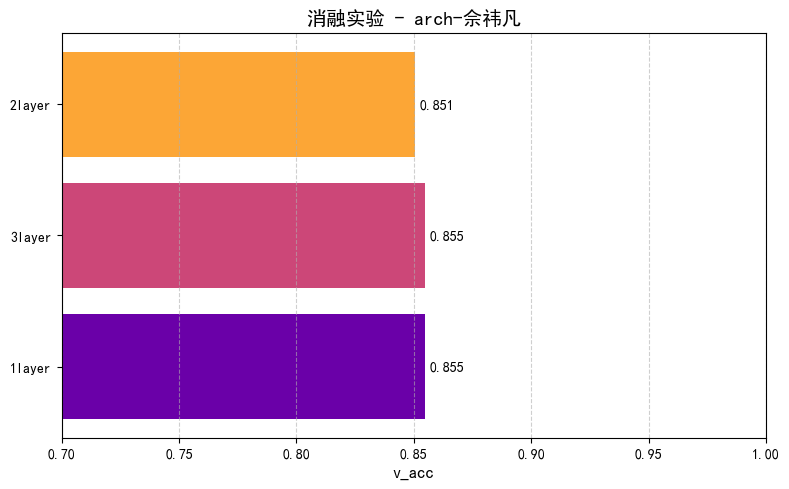

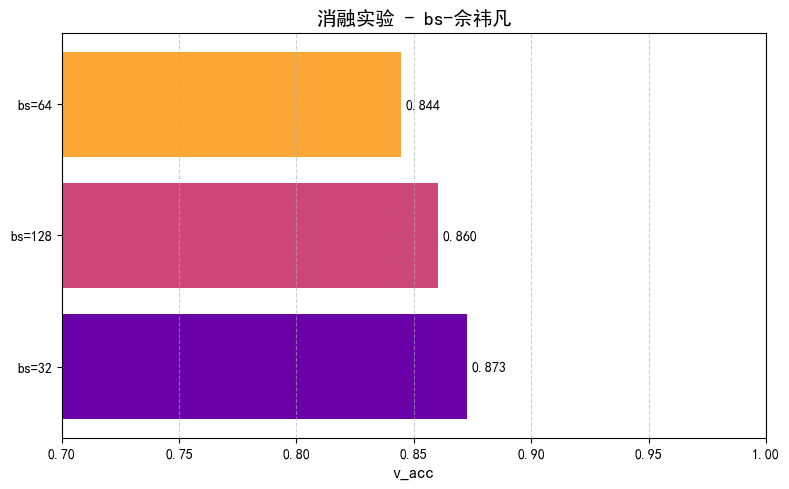

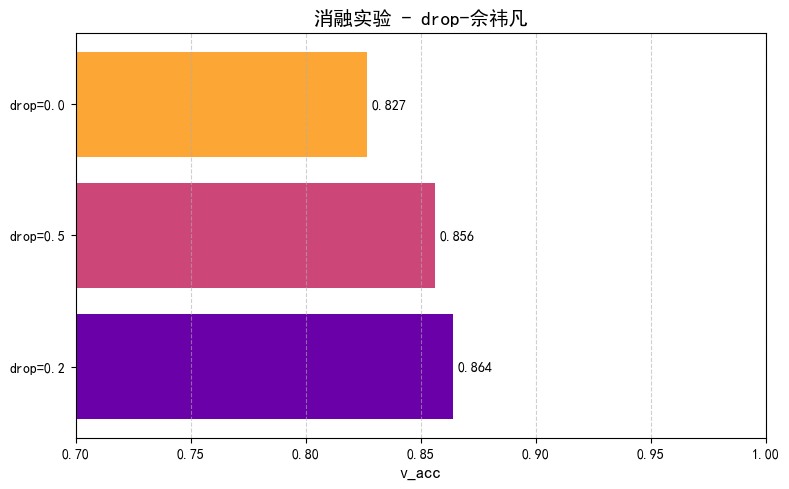

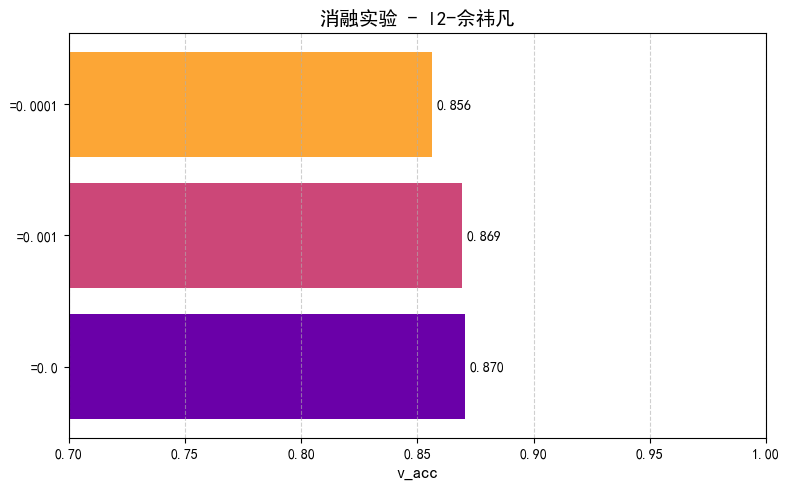

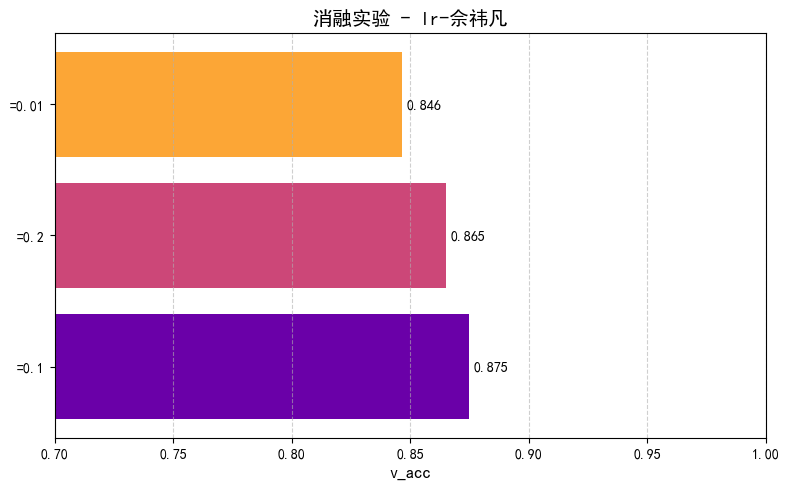

In [9]:
ablation_experiments()
plot_results_from_csv()

## 对激活函数的选取，层数layers,batchsize,dropout，l2正则化系数，以及learning_rate进行消融：

### 通过对初步的图表分析:
- 激活函数：Tanh效果最好达到了0.97。这可能是因为 Tanh 函数能够将输入值压缩到 -1 到 1 的范围内，相比其他激活函数如 ReLU，它能更好地处理负值输入，并且其输出的均值接近于 0，有助于加速神经网络的收敛。相比之下，ReLU 函数虽然计算效率高，但在某些情况下可能会导致神经元死亡问题，影响模型的训练效果；而 Sigmoid 函数由于输出范围在 0 到 1 之间，容易出现梯度消失问题，尤其是在深层网络中，这会阻碍模型的学习过程。
- 层数（layers）：本次训练3layer和1layer都达到了0.855，1、2、3层相差不大。当然这都不是绝对的，如果层数过深，有可能丢失最原始的信息，而层数过浅，网络的学习能力可能不足。
- batch_size：小的batch_size效果最好，小批量可以跳出局部最优，但训练时间较长，一般采取中等大小的batch_size效果比较平衡，由于消融实验此次训练次数较小，训练时间较短，故小的batch_size性能更好。
- dropout：由图表可看出设置为0.2时效果最好，达到了0.864最高，这很可能是由于适当的 dropout 率能够有效防止模型过拟合。在训练过程中，随机丢弃一部分神经元的输出，迫使模型学习到更具鲁棒性的特征表示，而不是依赖于某些特定的神经元。0.2 的 dropout 率在正则化和模型学习能力之间取得了较好的平衡，既能有效防止过拟合，又不会显著影响模型的学习效果。正常情况来说，该层和layer层的分析一致，过大过小都不适合模型的学习。
- l2正则化系数：l2最小时模型效果最好，惩罚效果弱，准确率高。小的 L2 正则化系数对模型的约束较弱，模型在训练集上的表现可能会较好，但容易出现过拟合现象。较大的 L2 正则化系数则会对模型的权重进行更强的约束，使模型倾向于学习到更简单的特征表示，有助于提高模型的泛化能力，由于模型本身没有学习特别充分，如果训练数据量充足，特征表达力强，可以适当提高惩罚力度，效果更好。
- learning_rate：本次任务0.1的学习率效果最好，学习率同样不适合过大或过小，过小收敛速度慢，且容易陷入局部最优，过大则容易发散，跳过最优点，所以选取合适的学习率最好。

#### 综上，通过消融实验对于各个超参数以及网络设置参数的分析可知，对于网络训练，没有绝对的定义，过大或过小也不一定都错（模型本身学习能力较弱或较强），对于具体的任务，以及具体的网络架构，需要选取一个合适的参数来实现最优效果，是没有定论的，应该具体问题具体分析。


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# ------------------- 1. 数据加载 -------------------
import numpy as np
import os

def load_idx_images(path):
    """
    读取 idx3-ubyte 原始图像文件（不压缩）
   
    """
    with open(path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')      # magic number
        num_images = int.from_bytes(f.read(4), 'big')
        rows = int.from_bytes(f.read(4), 'big')
        cols = int.from_bytes(f.read(4), 'big')
        # 一次性读入所有像素
        buffer = f.read(num_images * rows * cols)
    data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)/255.0
    data = data.reshape((num_images, rows, cols, 1))
    return data

def load_idx_labels(path):
    """
    读取 idx1-ubyte 原始标签文件（不压缩）
    返回 shape = (num_labels,)
    """
    with open(path, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')      # magic number
        num_labels = int.from_bytes(f.read(4), 'big')
        buffer = f.read(num_labels)
    labels = np.frombuffer(buffer, dtype=np.uint8)
    return labels

def load_data(base_path='.'):
    # 构造各文件完整路径
    train_images = os.path.join(base_path, 'train-images-idx3-ubyte')
    train_labels = os.path.join(base_path, 'train-labels-idx1-ubyte')
    test_images  = os.path.join(base_path, 't10k-images-idx3-ubyte')
    test_labels  = os.path.join(base_path, 't10k-labels-idx1-ubyte')

    # 读取
    x_train = load_idx_images(train_images)
    y_train = load_idx_labels(train_labels)
    x_test  = load_idx_images(test_images)
    y_test  = load_idx_labels(test_labels)

    # 划分验证集：取训练集最后 5000 条
    x_val, y_val = x_train[-5000:], y_train[-5000:]
    x_train, y_train = x_train[:-5000], y_train[:-5000]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)




同样的加载数据之后，来到了CNN,但是保留了二维图像的结构，卷积神经网络无非是对网络的深度，卷积核的大小及其相关参数的选择，以及后续的dropout层，pool层，通过各种的组合能够实现不一样的效果，
对语义分割，对边缘检测等等都可以配出很好的效果
要注意的一点就是输入维度，输出维度要匹配，否则很容易报错，
cnn可以直接将输入图片进行卷积，显然这样实现的效果要比flatten之后的全连接神经网络效果好。他能保留图片的信息，以及局部性关系。


In [2]:
#  2. CNN 模型定义
class MyCNN(tf.Module):
    def __init__(self, dropout_rate=0.3, l2_lambda=1e-4):
        super().__init__()
        self.l2_lambda = l2_lambda
        self.dropout_rate = dropout_rate

        self.conv1_w = tf.Variable(tf.random.normal([5, 5, 1, 16], stddev=0.1), name='conv1_w')
        self.conv1_b = tf.Variable(tf.zeros([16]), name='conv1_b')

        self.conv2_w = tf.Variable(tf.random.normal([3, 3, 16, 32], stddev=0.1), name='conv2_w')
        self.conv2_b = tf.Variable(tf.zeros([32]), name='conv2_b')

        self.fc1_w = tf.Variable(tf.random.normal([7*7*32, 128], stddev=0.1), name='fc1_w')
        self.fc1_b = tf.Variable(tf.zeros([128]), name='fc1_b')

        self.out_w = tf.Variable(tf.random.normal([128, 10], stddev=0.1), name='out_w')
        self.out_b = tf.Variable(tf.zeros([10]), name='out_b')

    def __call__(self, x, training=False):
        x = tf.nn.conv2d(x, self.conv1_w, strides=1, padding='SAME') + self.conv1_b
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')  # 14x14

        x = tf.nn.conv2d(x, self.conv2_w, strides=1, padding='SAME') + self.conv2_b
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')  # 7x7
        #最后输入softmax层的时候需要flatten
        x = tf.reshape(x, [-1, 7*7*32])
        x = tf.nn.relu(tf.matmul(x, self.fc1_w) + self.fc1_b)
        if training and self.dropout_rate > 0:
            x = tf.nn.dropout(x, rate=self.dropout_rate)

        logits = tf.matmul(x, self.out_w) + self.out_b
        probs = tf.nn.softmax(logits)
        return logits, probs

    def loss(self, logits, y_true):
        y_onehot = tf.one_hot(y_true, depth=10)
        ce = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_onehot, logits))
        l2 = sum(tf.nn.l2_loss(w) for w in [self.conv1_w, self.conv2_w, self.fc1_w, self.out_w])
        return ce + self.l2_lambda * l2


In [3]:
#  手动训练过程 
def train_cnn(epochs=30, lr=0.01, batch_size=64, dropout=0.3, l2_lambda=1e-4):
    (x_train, y_train), (x_val, y_val), (x_test, y_test) =load_data(base_path=r"C:\Users\LY\Desktop\ml2\archive")
    model = MyCNN(dropout_rate=dropout, l2_lambda=l2_lambda)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    train_loss, val_acc = [], []

    for epoch in range(epochs):
        idx = np.random.permutation(len(x_train))
        x_train, y_train = x_train[idx], y_train[idx]

        for i in range(0, len(x_train), batch_size):
            xb = x_train[i:i+batch_size]
            yb = y_train[i:i+batch_size]

            with tf.GradientTape() as tape:
                logits, probs = model(xb, training=True)
                loss = model.loss(logits, yb)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

# 验证
        _, val_probs = model(x_val, training=False)
        val_preds = tf.argmax(val_probs, axis=1)
        acc = np.mean(val_preds.numpy() == y_val)
        val_acc.append(acc)
        train_loss.append(loss.numpy())
        print(f"Epoch {epoch+1}: val_acc={acc:.4f}, train_loss={loss.numpy():.4f}")

    return model, train_loss, val_acc, (x_test, y_test)


In [4]:
#  可视化函数 
def plot_training_curve(train_loss, val_acc):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.title("train_loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_acc, label='Val Accuracy')
    plt.title("valid_acc")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  评估 
def evaluate_model(model, x_test, y_test):
    _, probs = model(x_test, training=False)
    preds = tf.argmax(probs, axis=1).numpy()
    print("分类报告：\n", classification_report(y_test, preds, digits=4))
    y_onehot = tf.one_hot(y_test, 10).numpy()
    auc = roc_auc_score(y_onehot, probs.numpy(), multi_class='ovo')
    print(f"AUC: {auc:.4f}")


Epoch 1: val_acc=0.8666, train_loss=0.5376
Epoch 2: val_acc=0.8580, train_loss=0.3535
Epoch 3: val_acc=0.8776, train_loss=0.1925
Epoch 4: val_acc=0.8878, train_loss=0.3836
Epoch 5: val_acc=0.8876, train_loss=0.4470
Epoch 6: val_acc=0.8976, train_loss=0.2263
Epoch 7: val_acc=0.8922, train_loss=0.2988
Epoch 8: val_acc=0.8786, train_loss=0.3121
Epoch 9: val_acc=0.8326, train_loss=0.4413
Epoch 10: val_acc=0.9040, train_loss=0.3027
Epoch 11: val_acc=0.9026, train_loss=0.2206
Epoch 12: val_acc=0.9044, train_loss=0.1678
Epoch 13: val_acc=0.9032, train_loss=0.2174
Epoch 14: val_acc=0.8980, train_loss=0.3845
Epoch 15: val_acc=0.8470, train_loss=0.4783
Epoch 16: val_acc=0.8946, train_loss=0.4510
Epoch 17: val_acc=0.8966, train_loss=0.3143
Epoch 18: val_acc=0.9120, train_loss=0.1025
Epoch 19: val_acc=0.9112, train_loss=0.1436
Epoch 20: val_acc=0.8978, train_loss=0.2684
Epoch 21: val_acc=0.8988, train_loss=0.2544
Epoch 22: val_acc=0.8996, train_loss=0.2159
Epoch 23: val_acc=0.9064, train_loss=0.15

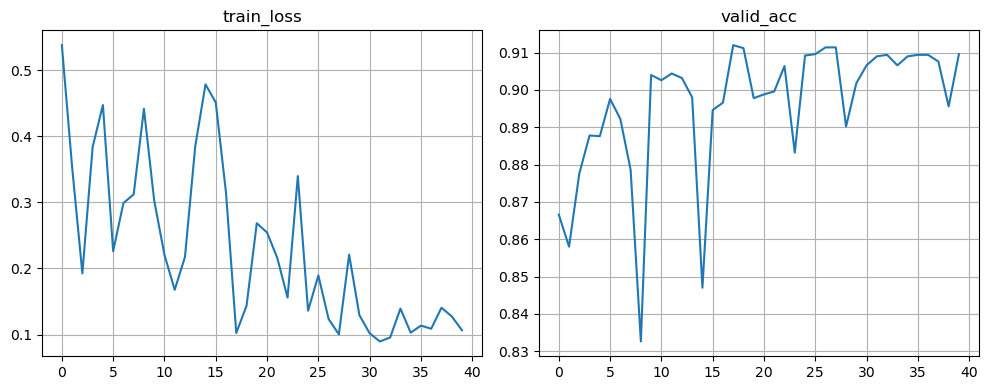

分类报告：
               precision    recall  f1-score   support

           0     0.8286    0.8700    0.8488      1000
           1     0.9960    0.9840    0.9899      1000
           2     0.8576    0.8670    0.8623      1000
           3     0.9151    0.9050    0.9100      1000
           4     0.8798    0.8560    0.8677      1000
           5     0.9751    0.9810    0.9781      1000
           6     0.7696    0.7380    0.7534      1000
           7     0.9579    0.9550    0.9564      1000
           8     0.9629    0.9860    0.9743      1000
           9     0.9661    0.9690    0.9675      1000

    accuracy                         0.9111     10000
   macro avg     0.9108    0.9111    0.9108     10000
weighted avg     0.9108    0.9111    0.9108     10000

AUC: 0.9932


In [5]:
model, loss_list, acc_list, (x_test, y_test) = train_cnn(epochs=40, lr=0.1, batch_size=64, dropout=0, l2_lambda=1e-4)
plot_training_curve(loss_list, acc_list)
evaluate_model(model, x_test, y_test)

整体分析和全连接神经网络一致，指标表明 CNN 在 Fashion-MNIST 测试集上 整体表现优秀、各类别均衡性较好，特别是 AUC说明模型具有极强的分类能力和泛化能力，相同的超参数设置下，虽然都未完全训练充分，但是cnn模型的效果明显好于fcnn,因为cnn保留了空间信息，且权重局部共享，无论是在训练上还是收敛性上都要更好，fcnn直接拉成一维向量，丢失空间信息，而且参数量巨大，模型拟合性相比较cnn差上许多。
### 凭借卷积的空间特征提取能力、参数共享和局部连接，cnn要优与fcnn。

下面进行消融实验，并将结果保存在文件夹中，直接读取绘图即可

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score

#  1. CNN搭建 
def build_model(filter_size=5, stride=1, padding='same', pool_type='max'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(8, (filter_size, filter_size), strides=(stride, stride), padding=padding,
                                     activation='relu', input_shape=(28,28,1)))
    if pool_type == 'max':
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    else:
        model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(16, (3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#  2. 训练并保存结果
def train_and_save(model, x_train, y_train, x_val, y_val, save_path, epochs=10, batch_size=64):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val), verbose=2)
    np.savez(save_path, loss=history.history['loss'], val_loss=history.history['val_loss'],
             acc=history.history['accuracy'], val_acc=history.history['val_accuracy'])
    print(f"结果保存到：{save_path}")

#  3. 消融实验 
def ablation_experiments(x_train, y_train, x_val, y_val):
    os.makedirs('消融实验佘祎凡', exist_ok=True)

    configs = [
        ('filter3', {'filter_size': 3}),
        ('filter5', {'filter_size': 5}),
        ('filter7', {'filter_size': 7}),
        ('stride1', {'stride': 1}),
        ('stride2', {'stride': 2}),
        ('padding_same', {'padding': 'same'}),
        ('padding_valid', {'padding': 'valid'}),
        ('pool_max', {'pool_type': 'max'}),
        ('pool_avg', {'pool_type': 'avg'})
    ]

    for name, params in configs:
        print(f"\n=== 正在训练 {name} ===")
        model = build_model(**params)
        save_path = f'消融实验佘祎凡/{name}.npz '
        train_and_save(model, x_train, y_train, x_val, y_val, save_path)



In [3]:
(x_train, y_train), (x_val, y_val), _ = load_data(base_path=r"C:\Users\LY\Desktop\ml2\archive")
ablation_experiments(x_train, y_train,x_val, y_val)


=== 正在训练 filter3 ===
Epoch 1/10
860/860 - 19s - loss: 0.5157 - accuracy: 0.8165 - val_loss: 0.3968 - val_accuracy: 0.8570 - 19s/epoch - 22ms/step
Epoch 2/10
860/860 - 10s - loss: 0.3523 - accuracy: 0.8737 - val_loss: 0.3389 - val_accuracy: 0.8764 - 10s/epoch - 12ms/step
Epoch 3/10
860/860 - 11s - loss: 0.3055 - accuracy: 0.8910 - val_loss: 0.3193 - val_accuracy: 0.8852 - 11s/epoch - 13ms/step
Epoch 4/10
860/860 - 11s - loss: 0.2772 - accuracy: 0.9005 - val_loss: 0.2974 - val_accuracy: 0.8908 - 11s/epoch - 12ms/step
Epoch 5/10
860/860 - 11s - loss: 0.2550 - accuracy: 0.9077 - val_loss: 0.2712 - val_accuracy: 0.9000 - 11s/epoch - 12ms/step
Epoch 6/10
860/860 - 10s - loss: 0.2348 - accuracy: 0.9142 - val_loss: 0.2637 - val_accuracy: 0.9064 - 10s/epoch - 12ms/step
Epoch 7/10
860/860 - 11s - loss: 0.2196 - accuracy: 0.9194 - val_loss: 0.2650 - val_accuracy: 0.9062 - 11s/epoch - 12ms/step
Epoch 8/10
860/860 - 11s - loss: 0.2031 - accuracy: 0.9257 - val_loss: 0.2490 - val_accuracy: 0.9100 - 

In [6]:
def plot_ablation_results(results_folder='ablation_results'):
    files = sorted(os.listdir(results_folder))
    labels = []
    best_val_accs = []

    for file in files:
        data = np.load(os.path.join(results_folder, file))
        val_acc = data['val_acc']
        labels.append(file.replace('.npz', ''))
        best_val_accs.append(np.max(val_acc))

    labels = np.array(labels)
    best_val_accs = np.array(best_val_accs)

    # 排序（从高到低）
    idx = np.argsort(best_val_accs)[::-1]
    labels = labels[idx]
    best_val_accs = best_val_accs[idx]

    # 开始画图
    plt.figure(figsize=(12, 8))
    bars = plt.barh(labels, best_val_accs, color=plt.cm.plasma(np.linspace(0.3, 0.8, len(labels))))
    plt.xlabel('Validation Accuracy', fontsize=14)
    plt.title('对比 佘祎凡', fontsize=16)
    plt.xlim(0.7, 1.0)  
    for bar, acc in zip(bars, best_val_accs):
        plt.text(acc + 0.002, bar.get_y() + bar.get_height()/2, f"{acc:.4f}", va='center', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


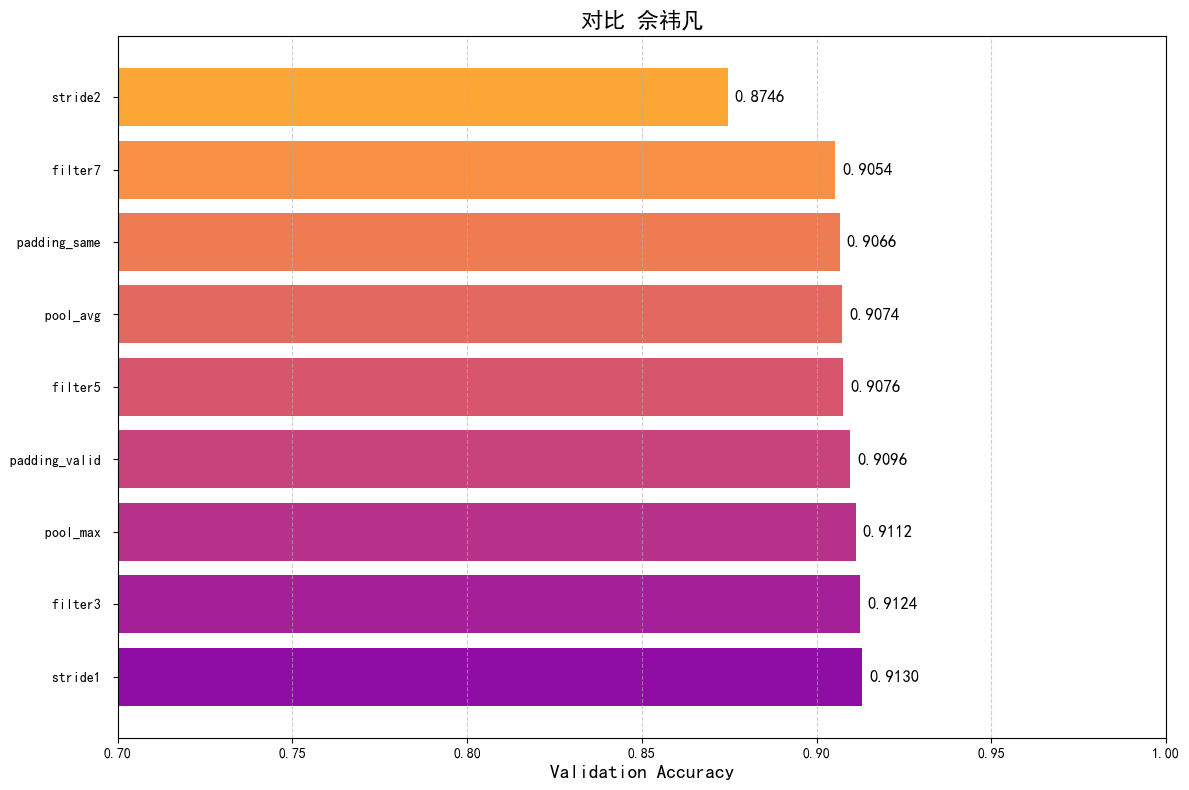

In [8]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用 SimHei 字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plot_ablation_results(results_folder='消融实验佘祎凡')

卷积核尺寸 3×3 达到最高准确率，说明小卷积核（3×3）更适合 Fashion-MNIST 数据集，通过捕捉细节，堆叠多个小卷积等效大卷积，增加非线性;
随着卷积核变大，性能略下降说明大卷积核可能过于模糊局部细节;
对于stride 看出stride=1 保留更多空间信息，对于本任务更适用;
padding_same 通过补零使输出大小等于输入保留边缘信息，padding_valid 丢弃边界信息，准确率略低，不过整体上差别不大，对于此任务还是'same'方式更合适。
对于pooling，差异不大，但平均池化略优 ，可能是对于此任务平均池化能更好平滑提取区域信息.